In [1]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

In [2]:
##### 目標式：放入最多的物件

##### 已加入的限制式
##### 1.物件不超出可行解區域
##### 2.物件間不可以重疊
##### 3.有些物件不可以包柱
##### 4.物件擺放數量上限
##### 5.物件擺放可以旋轉
##### 6.物件正面保留走道空間


In [3]:
##### 物件資料設置
### 0     1   2  3        4       5      6            7
### 名稱、長、寬、數量min、數量max、優先級、正面保留空間、是否可以包柱
objects = [
    ['Counter',465,66,1,1,1,160,False], #櫃台
    ['Back-Counter',598,66,1,1,1,90,True], #後櫃台
    ['Back-Work-Area',10,10,0,1,6,0,True], #後場作業區
    ['WI1',365,270,0,1,2,120,True], #WI1冷藏區
    ['WI2',365,225,0,1,2,120,True], #WI2冷藏區
    ['FF',60,66,5,7,5,90,False], #FF熱食區
    ['Dual-temp',90,90,1,1,3,120,False], #雙溫櫃(飯糰)
    ['Single-temp',90,90,4,4,3,120,False], #單溫櫃(鮮食)
    ['OC',90,90,3,3,3,120,False], #OC牛奶果汁
    #['Shelf'], #貨架
    ['RI1',310,225,1,1,4,120,False], #RI1冷凍區
    ['RI2',286,80,1,1,4,120,False], #RI2冷凍區
    ['MC1',130,90,1,1,6,90,False], #子母櫃1(冰品)
    ['MC2',190,90,1,1,6,90,False], #子母櫃2(冰品)
    ['EC',95,90,1,3,8,80,False], #EC區
    ['ATM',100,85,1,1,9,90,False], #ATM
    ['Photocopier',83,64,1,1,10,90,False], #影印機
    ['KIOSK',80,55,1,1,10,90,False], #KIOSK
    ['Single-Seat',93,93,0,10,11,90,False], #單人座位
    ['Double-Seat',170,50,0,10,11,90,False], #雙人座位
    ['Shared-Seat',240,190,0,0,11,90,False] #分享座位區
]


In [4]:
### 可行解區域
min_x = 0
max_x = 1578
min_y = 0
max_y = 1123

### 挖空 x、y、長、寬
empty_area = [ [0,0,1031,49],
               [1031,0,378,150],
               [1523,0,55,50],
               [0,1085,134,38],
               [134,965,131,158],
               [1528,162,50,802] ]

### 柱子 x、y、長、寬
pillar_area = [ [0,49,20,40],
                [0,543,20,40],
                [493,1079,34,44],
                [1003,1079,34,44],
                [1503,1079,34,44],
                [1508,543,20,40],
                [1508,50,20,40]  ]

In [5]:
wall = [ ['top',1123,265,1578],
         ['right',1578,964,1123],
         ['bottom',964,1529,1578],
         ['right',1528,162,964],
         ['top',162,1529,1578],
         ['right',1578,50,112],
         ['bottom',50,1523,1578],
         ['right',1523,0,50],
         ['bottom',0,1409,1523],
         ['left',1409,0,150] ]
window = [ ['left',0,49,1085 ],
           ['bottom',49,0,49,1031] ]
door = [ ['top',1085,0,134 ],
         ['right',134,965,1085],
         ['bottom',150,1031,1409]]

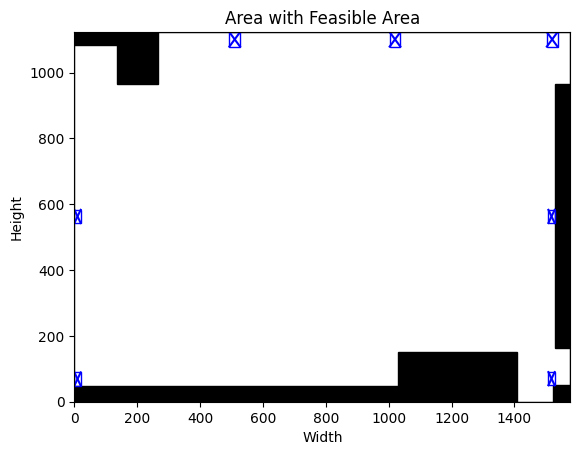

In [6]:
### 創建新圖
fig, ax = plt.subplots()

### 放置物件區域
ax.add_patch(plt.Rectangle((0, 0), max_x, max_y, edgecolor='black', facecolor='none'))

### 繪製 empty area
for i in range(len(empty_area)):
    x,y = empty_area[i][0], empty_area[i][1]
    width, height =  empty_area[i][2], empty_area[i][3]
    ax.add_patch(plt.Rectangle((x,y), width, height, edgecolor='black', facecolor='black'))
    
### 繪製 pillar area
for i in range(len(pillar_area)):
    x,y = pillar_area[i][0], pillar_area[i][1]
    width, height =  pillar_area[i][2], pillar_area[i][3]
    ax.add_patch(plt.Rectangle((x,y), width, height, edgecolor='blue', facecolor='none'))
    # 打叉標示柱子
    ax.plot([x, x + width], [y, y + height], color='blue')  # 左下到右上
    ax.plot([x, x + width], [y + height, y], color='blue')  # 左上到右下
    
### 設定x,y軸名稱、標題
ax.set_title('Area with Feasible Area')
ax.set_xlabel('Width')
ax.set_ylabel('Height')

### 座標範圍
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)

### 顯示圖形
plt.show()

In [7]:
##### 建立model
model = cp_model.CpModel()

In [8]:
##### 決定物件位置
### 0        1  2  3        4        5
### 物件名稱、x、y、是否放置、是否旋轉、正面位置
# obj_loc = []
obj_set = []
obj_start_num = []

count = 0
for obj_id, obj in enumerate(objects): # width, height
    
    obj_start_num.append(count)
    ### 根據每個物件需要的數量max(4)設置位置
    for i in range(obj[4]):
        obj_set.append([obj_id,0,0,False,False,False])
        obj_set[count][1] = model.NewIntVar(min_x, max_x - obj[1], f'obj_{obj_id}_{i}_x') # x
        obj_set[count][2] = model.NewIntVar(min_y, max_y - obj[2], f'obj_{obj_id}_{i}_y') # y
        obj_set[count][3] = model.NewBoolVar(f'obj_{obj_id}_{i}_set') # 是否放置
        obj_set[count][4] = model.NewBoolVar(f'obj_{obj_id}_{i}_rotate') # 是否旋轉
        obj_set[count][5] = model.NewBoolVar(f'obj_{obj_id}_{i}_front') # 正面位置
        #### 關係          front
        ####               true  false
        #### rotate  true  右邊   左邊
        ####        false  上面   下面
        count += 1
       

In [9]:
### 物件間的放置限制
for i in range(len(obj_set)):
    ### 物件間不可重疊
#     for j in range(i+1,len(obj_set)):
    for j in range(len(obj_set)):
        if(i==j):
            continue
        
        cond1 = model.NewBoolVar(f'intersect1_obj_{i}_{j}')
        cond2 = model.NewBoolVar(f'intersect2_obj_{i}_{j}')
        cond3 = model.NewBoolVar(f'intersect3_obj_{i}_{j}')
        cond4 = model.NewBoolVar(f'intersect4_obj_{i}_{j}')
        cond5 = model.NewBoolVar(f'intersect5_obj_{i}_{j}')
        cond6 = model.NewBoolVar(f'intersect6_obj_{i}_{j}')

        ### 加入旋轉限制        
        # obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + objects[obj_set[i][0]][2]*obj_set[i][4] 右邊
        # obj_set[i][2] + objects[obj_set[i][0]][2]*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] 上面

        model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*obj_set[i][4] <= obj_set[j][1]).OnlyEnforceIf(cond1) # 右1 <= 左2
        model.Add(obj_set[i][2] + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] <= obj_set[j][2]).OnlyEnforceIf(cond2) # 上1 <= 下2
        model.Add(obj_set[i][1] >= obj_set[j][1] + objects[obj_set[j][0]][1]*(1-obj_set[j][4]) + objects[obj_set[j][0]][2]*obj_set[j][4]).OnlyEnforceIf(cond3) # 左1 >= 右2
        model.Add(obj_set[i][2] >= obj_set[j][2] + objects[obj_set[j][0]][2]*(1-obj_set[j][4]) + objects[obj_set[j][0]][1]*obj_set[j][4]).OnlyEnforceIf(cond4) # 下1 >= 上2
        model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)
        model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond6)

        ### 加入正面預留空間 id=6
#             model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + objects[obj_set[i][0]][2]*obj_set[i][4] + objects[obj_set[i][0]][6]*(1-obj_set[i][5])*(1-obj_set[i][4]) <= obj_set[j][1]).OnlyEnforceIf(cond1) # 右1 <= 左2
#             model.Add(obj_set[i][2] + objects[obj_set[i][0]][2]*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] + objects[obj_set[i][0]][6]*(1-obj_set[i][5])*obj_set[i][4] <= obj_set[j][2]).OnlyEnforceIf(cond2) # 上1 <= 下2
#             model.Add(obj_set[i][1] - objects[obj_set[i][0]][6]*obj_set[i][5]*(1-obj_set[i][4]) >= obj_set[j][1] + objects[obj_set[j][0]][1]*(1-obj_set[j][4]) + objects[obj_set[j][0]][2]*obj_set[j][4]).OnlyEnforceIf(cond3) # 左1 >= 右2
#             model.Add(obj_set[i][2] - objects[obj_set[i][0]][6]*obj_set[i][5]*obj_set[i][4] >= obj_set[j][2] + objects[obj_set[j][0]][2]*(1-obj_set[j][4]) + objects[obj_set[j][0]][1]*obj_set[j][4]).OnlyEnforceIf(cond4) # 下1 >= 上2
#             model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)
#             model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond6)

        model.AddBoolOr([cond1, cond2, cond3, cond4, cond5, cond6])

    
    ### 不可以超過可行解區域    
    for j in range(0,len(empty_area)):
        cond1 = model.NewBoolVar(f'intersect1_empty_{i}_e{j}')
        cond2 = model.NewBoolVar(f'intersect2_empty_{i}_e{j}')
        cond3 = model.NewBoolVar(f'intersect3_empty_{i}_e{j}')
        cond4 = model.NewBoolVar(f'intersect4_empty_{i}_e{j}')
        cond5 = model.NewBoolVar(f'intersect5_empty_{i}_e{j}')

        model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*obj_set[i][4] <= empty_area[j][0]).OnlyEnforceIf(cond1) # 右1 <= 左2
        model.Add(obj_set[i][2] + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] <= empty_area[j][1]).OnlyEnforceIf(cond2) # 上1 <= 下2
        model.Add(obj_set[i][1] >= empty_area[j][0] + empty_area[j][2]).OnlyEnforceIf(cond3) # 左1 >= 右2
        model.Add(obj_set[i][2] >= empty_area[j][1] + empty_area[j][3]).OnlyEnforceIf(cond4) # 下1 >= 上2
        model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)

        model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

        
    ### 是否可以包柱
    if(objects[obj_set[i][0]][7]==False):
        for j in range(0,len(empty_area)):
            cond1 = model.NewBoolVar(f'intersect1_pillar_{i}_p{j}')
            cond2 = model.NewBoolVar(f'intersect2_pillar_{i}_p{j}')
            cond3 = model.NewBoolVar(f'intersect3_pillar_{i}_p{j}')
            cond4 = model.NewBoolVar(f'intersect4_pillar_{i}_p{j}')
            cond5 = model.NewBoolVar(f'intersect5_pillar_{i}_p{j}')

            model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*obj_set[i][4] <= pillar_area[j][0]).OnlyEnforceIf(cond1) # 右1 <= 左2
            model.Add(obj_set[i][2] + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] <= pillar_area[j][1]).OnlyEnforceIf(cond2) # 上1 <= 下2
            model.Add(obj_set[i][1] >= pillar_area[j][0] + pillar_area[j][2]).OnlyEnforceIf(cond3) # 左1 >= 右2
            model.Add(obj_set[i][2] >= pillar_area[j][1] + pillar_area[j][3]).OnlyEnforceIf(cond4) # 下1 >= 上2
            model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)

            model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

In [10]:
# ### 物件間的放置限制
# for i in range(len(obj_set)):
#     ### 物件間不可重疊
# #     for j in range(i+1,len(obj_set)):
#     for j in range(len(obj_set)):
#         if(i==j):
#             continue
#         else:
#             cond1 = model.NewBoolVar(f'intersect1_obj_{i}_{j}')
#             cond2 = model.NewBoolVar(f'intersect2_obj_{i}_{j}')
#             cond3 = model.NewBoolVar(f'intersect3_obj_{i}_{j}')
#             cond4 = model.NewBoolVar(f'intersect4_obj_{i}_{j}')
#             cond5 = model.NewBoolVar(f'intersect5_obj_{i}_{j}')
#             cond6 = model.NewBoolVar(f'intersect6_obj_{i}_{j}')

#             ### 加入旋轉限制        
#             # obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + objects[obj_set[i][0]][2]*obj_set[i][4] 右邊
#             # obj_set[i][2] + objects[obj_set[i][0]][2]*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] 上面

#             model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + objects[obj_set[i][0]][2]*obj_set[i][4] <= obj_set[j][1]).OnlyEnforceIf(cond1) # 右1 <= 左2
#             model.Add(obj_set[i][2] + objects[obj_set[i][0]][2]*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] <= obj_set[j][2]).OnlyEnforceIf(cond2) # 上1 <= 下2
#             model.Add(obj_set[i][1] >= obj_set[j][1] + objects[obj_set[j][0]][1]*(1-obj_set[j][4]) + objects[obj_set[j][0]][2]*obj_set[j][4]).OnlyEnforceIf(cond3) # 左1 >= 右2
#             model.Add(obj_set[i][2] >= obj_set[j][2] + objects[obj_set[j][0]][2]*(1-obj_set[j][4]) + objects[obj_set[j][0]][1]*obj_set[j][4]).OnlyEnforceIf(cond4) # 下1 >= 上2
#             model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)
#             model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond6)

#             model.AddBoolOr([cond1, cond2, cond3, cond4, cond5, cond6])

    
#     ### 不可以超過可行解區域    
#     for j in range(0,len(empty_area)):
#         cond1 = model.NewBoolVar(f'intersect1_empty_{i}_e{j}')
#         cond2 = model.NewBoolVar(f'intersect2_empty_{i}_e{j}')
#         cond3 = model.NewBoolVar(f'intersect3_empty_{i}_e{j}')
#         cond4 = model.NewBoolVar(f'intersect4_empty_{i}_e{j}')
#         cond5 = model.NewBoolVar(f'intersect5_empty_{i}_e{j}')

#         model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + objects[obj_set[i][0]][2]*obj_set[i][4] <= empty_area[j][0]).OnlyEnforceIf(cond1) # 右1 <= 左2
#         model.Add(obj_set[i][2] + objects[obj_set[i][0]][2]*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] <= empty_area[j][1]).OnlyEnforceIf(cond2) # 上1 <= 下2
#         model.Add(obj_set[i][1] >= empty_area[j][0] + empty_area[j][2]).OnlyEnforceIf(cond3) # 左1 >= 右2
#         model.Add(obj_set[i][2] >= empty_area[j][1] + empty_area[j][3]).OnlyEnforceIf(cond4) # 下1 >= 上2
#         model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)

#         model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

        
#     ### 是否可以包柱
#     if(objects[obj_set[i][0]][7]==False):
#         for j in range(0,len(empty_area)):
#             cond1 = model.NewBoolVar(f'intersect1_pillar_{i}_p{j}')
#             cond2 = model.NewBoolVar(f'intersect2_pillar_{i}_p{j}')
#             cond3 = model.NewBoolVar(f'intersect3_pillar_{i}_p{j}')
#             cond4 = model.NewBoolVar(f'intersect4_pillar_{i}_p{j}')
#             cond5 = model.NewBoolVar(f'intersect5_pillar_{i}_p{j}')

#             model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + objects[obj_set[i][0]][2]*obj_set[i][4] <= pillar_area[j][0]).OnlyEnforceIf(cond1) # 右1 <= 左2
#             model.Add(obj_set[i][2] + objects[obj_set[i][0]][2]*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] <= pillar_area[j][1]).OnlyEnforceIf(cond2) # 上1 <= 下2
#             model.Add(obj_set[i][1] >= pillar_area[j][0] + pillar_area[j][2]).OnlyEnforceIf(cond3) # 左1 >= 右2
#             model.Add(obj_set[i][2] >= pillar_area[j][1] + pillar_area[j][3]).OnlyEnforceIf(cond4) # 下1 >= 上2
#             model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)

#             model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

In [11]:
# # ##### 物件正面預留空間 id=6

# for i in range(len(obj_set)):
    
#     print("i =",i)
#     print(objects[obj_set[i][0]][2],objects[obj_set[i][0]][6])
    
#     for j in range(len(obj_set)):
#         if(i==j):
#             continue
        
#         ##### 正面為右邊
#         cond1 = model.NewBoolVar(f'aisle1_right_{i}_{j}')
#         cond2 = model.NewBoolVar(f'aisle2_right_{i}_{j}')
#         cond3 = model.NewBoolVar(f'aisle3_right_{i}_{j}')
#         cond4 = model.NewBoolVar(f'aisle4_right_{i}_{j}')
#         cond5 = model.NewBoolVar(f'aisle5_right_{i}_{j}')        
#         # x + height + aisle <= 左2
#         model.Add(obj_set[i][1] + objects[obj_set[i][0]][2] + objects[obj_set[i][0]][6] <= obj_set[j][1]).OnlyEnforceIf(cond1)
#         model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond2) # 1沒放
#         model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond3) # 2沒放
#         model.Add(obj_set[i][5] == False).OnlyEnforceIf(cond4) # 是右邊或上面
#         model.Add(obj_set[i][4] == False).OnlyEnforceIf(cond5) # 有轉 -> 右邊
        
#         model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])
        
#         ##### 正面為上面
#         cond1 = model.NewBoolVar(f'aisle1_top_{i}_{j}')
#         cond2 = model.NewBoolVar(f'aisle2_top_{i}_{j}')
#         cond3 = model.NewBoolVar(f'aisle3_top_{i}_{j}')
#         cond4 = model.NewBoolVar(f'aisle4_top_{i}_{j}')
#         cond5 = model.NewBoolVar(f'aisle5_top_{i}_{j}')        
#         # y + height + aisle <= 下2
#         model.Add(obj_set[i][2] + objects[obj_set[i][0]][2] + objects[obj_set[i][0]][6] <= obj_set[j][2]).OnlyEnforceIf(cond1)
#         model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond2) # 1沒放
#         model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond3) # 2沒放
#         model.Add(obj_set[i][5] == False).OnlyEnforceIf(cond4) # 是右邊或上面
#         model.Add(obj_set[i][4] == True).OnlyEnforceIf(cond5) # 沒轉 -> 上面
        
#         model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

#         ##### 正面為左邊
#         cond1 = model.NewBoolVar(f'aisle1_left_{i}_{j}')
#         cond2 = model.NewBoolVar(f'aisle2_left_{i}_{j}')
#         cond3 = model.NewBoolVar(f'aisle3_left_{i}_{j}')
#         cond4 = model.NewBoolVar(f'aisle4_left_{i}_{j}')
#         cond5 = model.NewBoolVar(f'aisle5_left_{i}_{j}')        
#         # x - aisle >= 右2
#         model.Add(obj_set[i][1] - objects[obj_set[i][0]][6] >= obj_set[j][1] + objects[obj_set[j][0]][1]*(1-obj_set[j][4]) + objects[obj_set[j][0]][2]*obj_set[j][4]).OnlyEnforceIf(cond1)
#         model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond2) # 1沒放
#         model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond3) # 2沒放
#         model.Add(obj_set[i][5] == True).OnlyEnforceIf(cond4) # 是左邊或下面
#         model.Add(obj_set[i][4] == False).OnlyEnforceIf(cond5) # 有轉 -> 左邊
        
#         model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])
        
        
#         ##### 正面為下面
#         cond1 = model.NewBoolVar(f'aisle1_bottom_{i}_{j}')
#         cond2 = model.NewBoolVar(f'aisle2_bottom_{i}_{j}')
#         cond3 = model.NewBoolVar(f'aisle3_bottom_{i}_{j}')
#         cond4 = model.NewBoolVar(f'aisle4_bottom_{i}_{j}')
#         cond5 = model.NewBoolVar(f'aisle5_bottom_{i}_{j}')        
#         # y - aisle >= 上2
#         model.Add(obj_set[i][2] - objects[obj_set[i][0]][6] >= obj_set[j][2] + objects[obj_set[j][0]][2]*(1-obj_set[j][4]) + objects[obj_set[j][0]][1]*obj_set[j][4]).OnlyEnforceIf(cond1)
#         model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond2) # 1沒放
#         model.Add(obj_set[j][3] == False).OnlyEnforceIf(cond3) # 2沒放
#         model.Add(obj_set[i][5] == True).OnlyEnforceIf(cond4) # 是左邊或下面
#         model.Add(obj_set[i][4] == True).OnlyEnforceIf(cond5) # 沒轉 -> 下面
        
#         model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

In [12]:
##### 物件數量限制
obj_num = []

### 數量需落再放置的最大最小值間
for i in range(len(objects)):
    obj_num.append(0)
    obj_num[i] = model.NewIntVar(objects[i][3], objects[i][4], f'obj_{obj_id}_num')
    
    start = obj_start_num[i]
    end = obj_start_num[i] + objects[i][4]
    model.Add( obj_num[i] == sum( obj_set[k][3] for k in range(start,end) ) )

### 兩種size的WI只需放一個 id=3,4
model.Add( obj_num[3] + obj_num[4] == 1 )    


In [13]:
# ##### 物件靠牆限制
# for i in range(len(obj_set)):
    
#         cond1 = model.NewBoolVar(f'intersect1_wall_{i}')
#         cond2 = model.NewBoolVar(f'intersect2_wall_{i}')
#         cond3 = model.NewBoolVar(f'intersect3_wall_{i}')
#         cond4 = model.NewBoolVar(f'intersect4_wall_{i}')
#         cond5 = model.NewBoolVar(f'intersect5_wall_{i}')

#         model.Add(obj_set[i][1] + objects[obj_set[i][0]][1]*(1-obj_set[i][4]) + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*obj_set[i][4] == max_x).OnlyEnforceIf(cond1) # 右靠牆
#         model.Add(obj_set[i][2] + (objects[obj_set[i][0]][2]+objects[obj_set[i][0]][6])*(1-obj_set[i][4]) + objects[obj_set[i][0]][1]*obj_set[i][4] == max_y).OnlyEnforceIf(cond2) # 上靠牆
#         model.Add(obj_set[i][1] == min_x).OnlyEnforceIf(cond3) # 左靠牆
#         model.Add(obj_set[i][2] == min_y).OnlyEnforceIf(cond4) # 下靠牆
#         model.Add(obj_set[i][3] == False).OnlyEnforceIf(cond5)

# #         model.AddBoolOr([cond3, cond4, cond5])
#         model.AddBoolOr([cond1, cond2, cond3, cond4, cond5])

In [14]:
### Objective Function
set_area = sum(objects[obj_set[i][0]][1] * objects[obj_set[i][0]][2] * obj_set[i][3] for i in range(len(obj_set)))
model.Maximize(set_area)

In [15]:
### solution
solver = cp_model.CpSolver()
status = solver.Solve(model)

In [16]:
### print solution
if status == cp_model.OPTIMAL:
    print('放置物件面積總和：', solver.ObjectiveValue())
    for i in range(len(obj_set)):        
        if(solver.Value(obj_set[i][3])):
            print(i,objects[obj_set[i][0]][0],'位置(x, y):', solver.Value(obj_set[i][1]), solver.Value(obj_set[i][2]))
#             print("Rotate",solver.Value(obj_set[i][4]),"Front",solver.Value(obj_set[i][5]))
        else:
            print(i,objects[obj_set[i][0]][0],'未放置')
    print()
    for i in range(len(objects)):
        print(objects[i][0],"放置的數量",solver.Value(obj_num[i]))
else:
    print('未找到最佳解')
    


放置物件面積總和： 598110.0
0 Counter 位置(x, y): 29 663
1 Back-Counter 位置(x, y): 978 1053
2 Back-Work-Area 位置(x, y): 1509 0
3 WI1 位置(x, y): 575 50
4 WI2 未放置
5 FF 位置(x, y): 1464 110
6 FF 位置(x, y): 0 583
7 FF 位置(x, y): 451 982
8 FF 位置(x, y): 1509 964
9 FF 位置(x, y): 1509 50
10 FF 位置(x, y): 1033 822
11 FF 位置(x, y): 66 490
12 Dual-temp 位置(x, y): 575 753
13 Single-temp 位置(x, y): 224 523
14 Single-temp 位置(x, y): 607 843
15 Single-temp 位置(x, y): 1229 936
16 Single-temp 位置(x, y): 134 340
17 OC 位置(x, y): 494 660
18 OC 位置(x, y): 942 822
19 OC 位置(x, y): 517 843
20 RI1 位置(x, y): 265 89
21 RI2 位置(x, y): 1229 650
22 MC1 位置(x, y): 1359 480
23 MC2 位置(x, y): 1274 150
24 EC 位置(x, y): 1037 340
25 EC 位置(x, y): 808 1033
26 EC 位置(x, y): 1134 616
27 ATM 位置(x, y): 857 933
28 Photocopier 位置(x, y): 1274 390
29 KIOSK 位置(x, y): 1304 570
30 Single-Seat 位置(x, y): 265 889
31 Single-Seat 位置(x, y): 20 889
32 Single-Seat 位置(x, y): 1037 523
33 Single-Seat 位置(x, y): 358 889
34 Single-Seat 位置(x, y): 715 660
35 Single-Seat 位置(x, y): 

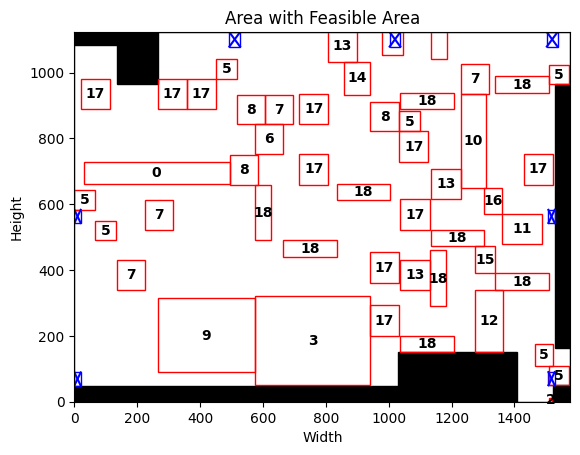

In [17]:
### 創建新圖
fig, ax = plt.subplots()

### 放置物件區域
ax.add_patch(plt.Rectangle((0, 0), max_x, max_y, edgecolor='black', facecolor='none'))

### 繪製 empty area
for i in range(len(empty_area)):
    x,y = empty_area[i][0], empty_area[i][1]
    width, height =  empty_area[i][2], empty_area[i][3]
    ax.add_patch(plt.Rectangle((x,y), width, height, edgecolor='black', facecolor='black'))
    
### 繪製 pillar area
for i in range(len(pillar_area)):
    x,y = pillar_area[i][0], pillar_area[i][1]
    width, height =  pillar_area[i][2], pillar_area[i][3]
    ax.add_patch(plt.Rectangle((x,y), width, height, edgecolor='blue', facecolor='none'))
    # 打叉標示柱子
    ax.plot([x, x + width], [y, y + height], color='blue')  # 左下到右上
    ax.plot([x, x + width], [y + height, y], color='blue')  # 左上到右下

### 繪製有放置的物體
for i in range(len(obj_set)):
    if(solver.Value(obj_set[i][3])):
        x,y = solver.Value(obj_set[i][1]), solver.Value(obj_set[i][2])
        rotate = solver.Value(obj_set[i][4])
        width = objects[obj_set[i][0]][1] * (1-rotate) + objects[obj_set[i][0]][2] * rotate
        height = objects[obj_set[i][0]][2] * (1-rotate) + objects[obj_set[i][0]][1] * rotate
        ax.add_patch(plt.Rectangle((x,y), width, height, edgecolor='red', facecolor='none'))
        ax.annotate(obj_set[i][0], (x + width/2, y + height/2), color='black', weight='bold', fontsize=10,
                ha='center', va='center')

### 設定x,y軸名稱、標題
ax.set_title('Area with Feasible Area')
ax.set_xlabel('Width')
ax.set_ylabel('Height')

### 座標範圍
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)

### 顯示圖形
plt.show()